In [2]:
using Particles, Distributions, ConjugatePriors
using ConjugatePriors: NormalInverseWishart

INFO: Recompiling stale cache file /home/dave/.julia/lib/v0.6/ConjugatePriors.ji for module ConjugatePriors.


# Stickiness

Want to model "sticky" transitions between components (in order to deal with runs).  There are a few complications: need to take into account the ambiguity in same-component transitions (could be that you randomly picked the same, or that you stuck), and that affects how you count state assignments for CRP purposes (as well as sampling new values for the stickiness parameter which is important).

## `particles` state prior with stickiness: ✔

Currently: sufficient statistics are stored on components.  Need to augment those to keep track of self-transitions (in addition to total state occupations).  Ideally this could be handled with a generalized representation of the state transition prior in the particle/component somehow.  Where does that information come in?

* `fit(p::Particle, y, x::Int)`: use trickery to efficiently get the log-probability ratio, by subtracting/adding the log-count.
* `marginal_log_posterior`

How about replacing α with a prior struct?  Then need to be able to do

* prior probability given current state. (requires different sufficient statistics potentially)
* joint prior probability of a bunch of observations with labels already.

Question is then where you put the sufficient statistics...

I mean you could replace the `Particle/InfiniteParticle` distinction with this too since you really do the putative index generation based on the prior.  But is that really worth it??  Need to encapsulate the sufficient stats for the prior somehow, but why not do that _on the prior struct_ itself?  A la the `Component` abstraction...

## CRP component of sticky state prior

One subtlety is in how to properly compute the state-transition prior when there's a constant stickiness.  The generative model is simple enough: sample a "sticky" indicator with constant probability $s_i \sim \mathrm{Bernoulli}(\rho)$, and conditional on that the following state (same if $s_i = 1$, from a Chinese Restaurant Process otherwise.  The issue is that when the state doesn't change, that could be because of stickiness _or_ because that state was randomly chosen as a non-sticky transition.  And _that_ depends on how likely each state is a priori, and hence on whether other, previous assignments to that state are stickiness or not, etc....

The basic difficulty is that the CRP requries that you be able to integrate out the actual parameter which has the state probabilities.  I don't know that that's really possible here, unfortunately.

Now I see why the HDP-HMM approach is very clever.  Using a hierarchical approach lets you use the counts for transitions from each state encode the stickiness: you put your thumb on the scale with their $\kappa$ param, which then leads to more self-transitions when there's less data which gets perpetuated in the following trials via the normal CRP dynamics.

How to deal with this?  Could explicitly include the "stickiness" indicator variables in the particle state.  Or go to the hierarchical direction.  Or something where we take the limit of infinite lower-level concentration parameter, plus constant $\kappa/\alpha$ ratio?

### Stickiness/override indicator variable in state

In this formulation, there's an additional putative particle with prior weight $\rho$ generated with the same state as the predecessor, and the other particles weights are adjusted by $(1-\rho)$.  This seems quite straightforward, and could even use a special sentinal value of the state (like 0 or -1) to indicate this.  Then keep track of the number of sticking transitions and use that to sample $\rho$ (from a Beta or something).

In [3]:
using JLD2, DataFrames, Underscore, DataFramesMeta

@load "data/dots2014.jld2" recall pred

2-element Array{Symbol,1}:
 :recall
 :pred  

In [4]:
recall

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp
1,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275
2,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054
3,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827
4,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544
5,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778
6,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024
7,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0
8,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059
9,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423
10,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689


In [5]:
prior = NormalInverseWishart(zeros(2), 0.1, eye(2)*0.1*3, 3.)
α = 1.0
ps = ChenLiuParticles(100, prior, ChineseRestaurantProcess(α))

Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}[0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle  …  0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle]

Particle filter with 100 particles:


In [6]:
using JuliennedArrays

xys = @with(@where(recall, :subjid1 .== 1), hcat(:x, :y))
xy_vecs = map(vec, julienne(xys, (*,:)))

200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [0.0318469, 0.00562752]   
 [0.0278656, 0.000370634]  
 [-0.0160184, -0.000520783]
 [0.0504518, -0.00401431]  
 [-0.0312425, -0.000984465]
 [0.00850297, -0.000448522]
 [0.0312967, 0.00292533]   
 [0.0355355, 0.00415872]   
 [-0.00730868, 0.00151658] 
 [0.0403416, -0.00260159]  
 [0.00976546, 0.00171756]  
 [0.0023686, 0.000115442]  
 [0.0546225, 0.00575101]   
 ⋮                         
 [-0.0525185, -0.20348]    
 [-0.0952235, -0.151854]   
 [-0.0422029, -0.226154]   
 [-0.235441, -0.377386]    
 [-0.0520006, -0.241261]   
 [-0.075919, -0.262445]    
 [-0.0902533, -0.158258]   
 [-0.123231, -0.187603]    
 [-0.293629, -0.247625]    
 [-0.151276, -0.262387]    
 [-0.0930733, -0.447663]   
 [-0.230315, -0.340811]    

In [7]:
filter!(ps, xy_vecs)

Fitting particles... 76%|███████████████████████        |  ETA: 0:00:00
Fitting particles...100%|███████████████████████████████| Time: 0:00:01

Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}[5+ Particle, 5+ Particle, 5+ Particle, 5+ Particle, 4+ Particle, 4+ Particle, 5+ Particle, 4+ Particle, 4+ Particle, 5+ Particle  …  5+ Particle, 4+ Particle, 4+ Particle, 4+ Particle, 4+ Particle, 4+ Particle, 4+ Particle, 5+ Particle, 4+ Particle, 4+ Particle]

In [8]:
weight.(ps.particles)

Particle filter with 100 particles:


100-element Array{Float64,1}:
 0.00928945
 0.0100565 
 0.0100565 
 0.0102312 
 0.0113671 
 0.0105928 
 0.0101254 
 0.0101234 
 0.0101234 
 0.00928945
 0.00866626
 0.00953143
 0.0106731 
 ⋮         
 0.00966927
 0.00947372
 0.0102312 
 0.0101263 
 0.0107276 
 0.00956564
 0.00929004
 0.0101631 
 0.0103492 
 0.0105883 
 0.0105388 
 0.0101728 

In [9]:
sort!(ps.particles, by=weight)

100-element Array{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess},1}:
 5+ Particle
 4+ Particle
 5+ Particle
 5+ Particle
 5+ Particle
 5+ Particle
 6+ Particle
 6+ Particle
 5+ Particle
 5+ Particle
 5+ Particle
 5+ Particle
 5+ Particle
 ⋮          
 4+ Particle
 4+ Particle
 4+ Particle
 5+ Particle
 4+ Particle
 4+ Particle
 4+ Particle
 4+ Particle
 4+ Particle
 4+ Particle
 4+ Particle
 4+ Particle

In [10]:
assignments(ps)

200×100 Array{Int64,2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  

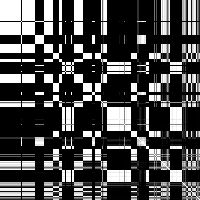

In [11]:
using Colors, Images
Gray.(assignment_similarity(ps))

In [12]:
sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.5))
filter!(sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[8+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 8+ Particle, 9+ Particle, 9+ Particle, 8+ Particle, 9+ Particle, 9+ Particle  …  9+ Particle, 9+ Particle, 8+ Particle, 8+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle]

Particle filter with 100 particles:


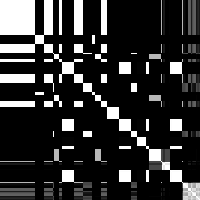

In [13]:
Gray.(assignment_similarity(sticky_ps))

In [14]:
really_sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.9))
filter!(really_sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle  …  8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle]

Particle filter with 100 particles:


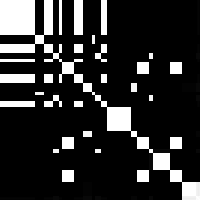

In [15]:
Gray.(assignment_similarity(really_sticky_ps))

In [16]:
barely_sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.1))
filter!(barely_sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[7+ Particle, 7+ Particle, 6+ Particle, 7+ Particle, 7+ Particle, 6+ Particle, 6+ Particle, 7+ Particle, 6+ Particle, 6+ Particle  …  7+ Particle, 6+ Particle, 6+ Particle, 6+ Particle, 6+ Particle, 7+ Particle, 6+ Particle, 6+ Particle, 6+ Particle, 6+ Particle]

Particle filter with 100 particles:


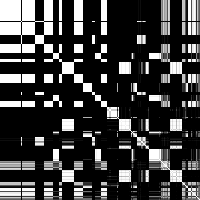

In [17]:
Gray.(assignment_similarity(barely_sticky_ps))

Fitting particles...100%|███████████████████████████████| Time: 0:00:03


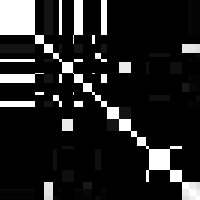

In [18]:
using Underscore

@_ ChenLiuParticles(100, prior, StickyCRP(10., 0.9)) |>
    filter!(_, xy_vecs) |>
    assignment_similarity |>
    Gray.(_)

# Data by subject

In [19]:
sub1 = @where(recall, :subjid1 .== 1)
sub2 = @where(recall, :subjid1 .== 2)

using Plots, StatPlots

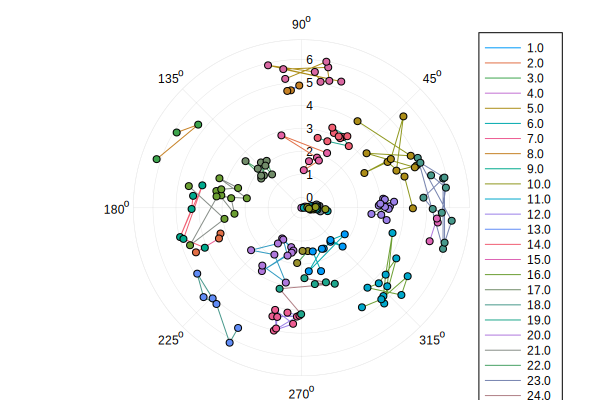

In [20]:
@with(sub1, plot(:theta, :rho, group=:block, seriestype=[^(:path), ^(:scatter)], proj=^(:polar)))

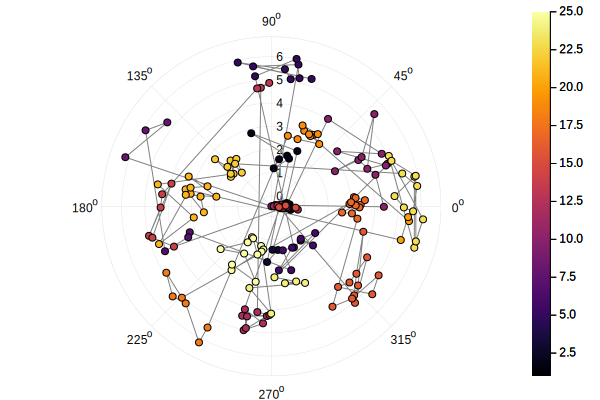

In [21]:
@df sub1 plot(:theta, :rho, seriestype=:path, proj=:polar, color="gray")
@df sub1 plot!(:theta, :rho, seriestype=:scatter, markerz=:block, legend=false)

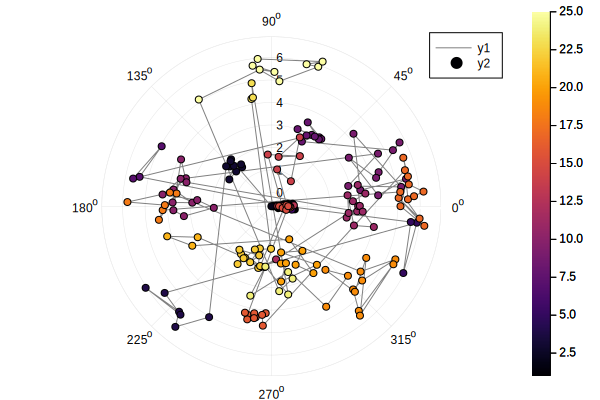

In [22]:
@df sub2 plot(:theta, :rho, seriestype=:path, proj=:polar, color="gray")
@df sub2 plot!(:theta, :rho, markerz=:block, seriestype=:scatter)

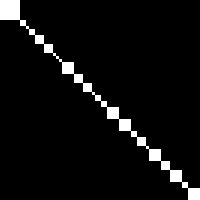

In [23]:
Gray.(@with(sub1, :block .== :block'))

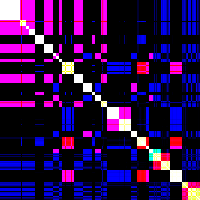

In [24]:
colorview(RGB, assignment_similarity(really_sticky_ps), @with(sub1, :block .== :block'), assignment_similarity(ps))

In [25]:
p = really_sticky_ps.particles[1]

  ConjugatePriors.NormalInverseWishart{Float64}([0.0307026, -0.0198556], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.756188 -0.2258; 0.0 1.22999], 62.1, 65.0) w/ n=62
  ConjugatePriors.NormalInverseWishart{Float64}([0.0306688, 0.826453], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.73823 0.0154144; 0.0 0.647673], 12.1, 15.0) w/ n=12
  ConjugatePriors.NormalInverseWishart{Float64}([-0.618566, 0.029639], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.820099 -0.203813; 0.0 1.085], 16.1, 19.0) w/ n=16
  ConjugatePriors.NormalInverseWishart{Float64}([0.603704, 0.214748], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[1.7438 -0.941973; 0.0 1.08955], 36.1, 39.0) w/ n=36
  ConjugatePriors.NormalInverseWishart{Float64}([-0.282505, -0.669002], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[1.02803 -0.138166; 0.0 0.698693], 15.1, 18.0) w/ n=15
  ConjugatePriors.NormalInverseWishart{Float64}([0.513126, -0.234124], Bas

In [26]:
p.stateprior

Particle with 8+ components:


Particles.StickyCRP(1.0, 0.9, 8, [24.0, 2.0, 4.0, 3.0, 2.0, 1.0, 1.0, 1.0], [58.0, 10.0, 13.0, 33.0, 13.0, 23.0, 16.0, 17.0])

# Modeling recall

Recall is a combination of the actual remembered location and the category.  If the distributions are both normal then it's just the inverse-variance weighted average of the means.  I'm not sure how that works when there's uncertainty about the actual distribution...but it might be close enough when there's more than a few observations from the category.  Or not.  At the very least could sample from the posterior and then do the combination.

The precision-weighted average model of cue combination comes from a normal-normal model.  The normal-inverse-wishart model is a normal-normal model, conditioned on a sample of the variance.  So we can approximate it in one of two ways: sample a few covariance matrices and average the resulting predictions, or use the expected covariance matrix as a good guess.

Either way we have to average over particles anyway...

In [27]:
p.assignment

8

In [28]:
c = p.components[1]

typeof(c)

Particles.Component{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats}

In [29]:
fieldnames(c)

2-element Array{Symbol,1}:
 :prior    
 :suffstats

In [30]:
using ConjugatePriors: posterior

In [31]:
post = posterior(c.prior, c.suffstats)

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0307026, -0.0198556]
kappa: 62.1
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.756188 -0.2258; 0.0 1.22999]
nu: 65.0
)


The predictive distribution is Normal, with covariance $S_{mem} = \Sigma_n + \kappa_n^{-1}\Sigma_n = \frac{1+\kappa_n}{\kappa_n} \Sigma_N = \frac{1+\kappa_n}{\kappa_n (\nu_n - d + 1)} \Lambda_n $.  The precision is $S_{mem}^{-1} = \frac{\kappa_n (\nu_n - d + 1)}{1+\kappa_n} \Lambda_n^{-1}$

Combine that with a uncertain memory trace which is going to have MvNormal uncertainty with covariance $S_x$ and mean $x$...

Then the reconstructed (recalled) value is the inverse-variance weighted estimate:

$$\hat{x} = (S_{mem}^{-1} + S_x^{-1})^{-1} (S_{mem}^{-1} \mu + S_x^{-1} x)$$

In [32]:
using BenchmarkTools

@btime full(inv($(post.Lamchol)))
@btime inv(full($(post.Lamchol)))

full(inv(post.Lamchol)) == inv(full(post.Lamchol))

  218.140 ns (2 allocations: 128 bytes)
  926.381 ns (15 allocations: 1.94 KiB)


false

In [33]:
using Distributions: MvNormalStats

ConjugatePriors.posterior(c::Component) = posterior(c.prior, c.suffstats)

function recall_est(x::AbstractVector{Float64}, Sx::Matrix{Float64}, c::Component{NormalInverseWishart{Float64}}) 
    Sinv_x = inv(Sx)
    post = posterior(c)
    Sinv_mem = full(inv(post.Lamchol)) .* (post.kappa / (1+post.kappa) * (post.nu - post.dim + 1))
    Sinv_total = Sinv_x + Sinv_mem
    return Sinv_total \ (Sinv_mem * post.mu + Sinv_x * x)
end

recall_est (generic function with 1 method)

In [34]:
xy_vecs[end]

2-element SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true}:
 -0.230315
 -0.340811

In [35]:
recall_est(xy_vecs[end], eye(2), p.components[p.assignment])

2-element Array{Float64,1}:
 -0.0721766
 -0.333211 

## Filtering

Now we need to add some kind of method to filter a data point and aggregate the estimates as we go.  The `filter!` method takes a vector of observations and just calls `fit!` on each one.  Could add some kind of callback to that, or just do it manually.

In [36]:
function Base.reset(particles::ChenLiuParticles) 
    N = length(particles.particles)
    p = particles.particles[1]
    return ChenLiuParticles(N, p.prior.prior, p.stateprior; rejuv=particles.rejuvination_threshold)
end

In [37]:
extrema(xys, 1)

1×2 Array{Tuple{Float64,Float64},2}:
 (-0.933307, 0.968406)  (-0.869892, 0.939818)

In [38]:
# This ONLY MAKES SENSE when x is the last datapoint fit (e.g., as a callback from filter!)

function recall_est(x::AbstractVector, Sx::Matrix, ps::ParticleFilter)
    xy_recalled = mapreduce(p -> recall_est(x, Sx, p.components[p.assignment]) .* weight(p), +, ps.particles)
    xy_recalled ./= sum(weight.(ps.particles))
    return xy_recalled
end


recall_est (generic function with 2 methods)

In [39]:
Sx = eye(2) * sqrt(0.01)
recalled = Vector{Vector{Float64}}()
ps2 = filter!(ChenLiuParticles(1000, prior, StickyCRP(α, 0.9)), xy_vecs, 
              cb=(p,y)->push!(recalled, recall_est(y, Sx, p)))

Fitting particles...100%|███████████████████████████████| Time: 0:00:24


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[10+ Particle, 9+ Particle, 10+ Particle, 10+ Particle, 9+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 9+ Particle  …  8+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 9+ Particle, 10+ Particle, 10+ Particle, 9+ Particle, 10+ Particle, 10+ Particle]

Particle filter with 1000 particles:


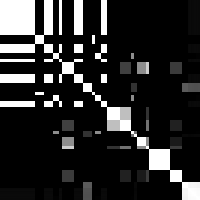

In [40]:
Gray.(assignment_similarity(ps2))

In [41]:
recalled

200-element Array{Array{Float64,1},1}:
 [0.0308519, 0.0054517]     
 [0.0281303, 0.0015448]     
 [0.000554627, 0.000737141] 
 [0.0336065, -0.00134185]   
 [-0.00266282, -0.000279085]
 [0.0106697, -0.000139061]  
 [0.01915, 0.00110875]      
 [0.0217771, 0.00170841]    
 [0.00921745, 0.00107726]   
 [0.0220718, -9.59695e-5]   
 [0.014922, 0.000900933]    
 [0.0126565, 0.00054541]    
 [0.0247673, 0.0018788]     
 ⋮                          
 [-0.0111392, -0.33058]     
 [0.00667799, -0.123043]    
 [0.0179475, -0.101652]     
 [-0.0907937, -0.436187]    
 [-0.0324933, -0.332223]    
 [-0.0368426, -0.325847]    
 [-0.025601, -0.215646]     
 [-0.0307894, -0.204778]    
 [-0.115038, -0.320154]     
 [-0.0835197, -0.323598]    
 [-0.0682433, -0.391426]    
 [-0.106975, -0.353161]     

In [42]:
norm.(recalled .- xy_vecs)

200-element Array{Float64,1}:
 0.00101042
 0.00120365
 0.0166207 
 0.017056  
 0.0285884 
 0.00218867
 0.0122818 
 0.0139749 
 0.016532  
 0.0184408 
 0.00522076
 0.0102968 
 0.0301052 
 ⋮         
 0.133667  
 0.105896  
 0.138271  
 0.156142  
 0.09303   
 0.0744761 
 0.0864481 
 0.0940231 
 0.192757  
 0.0913109 
 0.0614744 
 0.123957  

In [43]:
norm.(recalled) .- norm.(xy_vecs)

200-element Array{Float64,1}:
 -0.00101042 
  0.000304661
 -0.0151044  
 -0.016978   
 -0.0285806  
  0.00215577 
 -0.0122511  
 -0.013934   
  0.00181582 
 -0.0183533  
  0.00503378 
  0.0102968  
 -0.0300859  
  ⋮          
  0.12062    
 -0.0560159  
 -0.126834   
  0.000730133
  0.0870066  
  0.0547174  
  0.0349755  
 -0.0173763  
 -0.0439098  
  0.0313304  
 -0.0599054  
 -0.0423288  

In [44]:
xy_resp_vecs = @_ recall |> 
    @where(_, :subjid1 .== 1) |> 
    @with(_, hcat(:x_resp, :y_resp)) |> 
    map(vec, julienne(_, (*,:)))

200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [-0.010458, -0.0418275]  
 [0.00813932, -0.00465054]
 [-0.0685536, -0.0278827] 
 [0.070865, -0.0348544]   
 [0.0941047, -0.0859778]  
 [-0.0267245, -0.0488024] 
 [0.103403, 0.0]          
 [-0.0267275, -0.0883059] 
 [-0.0197503, 0.0139423]  
 [0.0197581, 0.00929689]  
 [0.00116183, 0.0]        
 [-0.00348551, 0.00464732]
 [0.019753, -0.0441498]   
 ⋮                        
 [0.00812914, -0.132454]  
 [-0.05229, -0.123161]    
 [-0.117332, -0.23934]    
 [-0.321814, -0.427567]   
 [-0.18474, -0.146389]    
 [-0.140581, -0.188224]   
 [-0.0360104, -0.111532]  
 [-0.161493, -0.202172]   
 [-0.245143, -0.206814]   
 [-0.268382, -0.239356]   
 [-0.0801695, -0.313703]  
 [-0.219569, -0.362502]   

In [45]:
resp_dev_rad = norm.(xy_vecs .- xy_resp_vecs)

200-element Array{Float64,1}:
 0.0635742 
 0.0203553 
 0.0592336 
 0.0369839 
 0.151446  
 0.0598253 
 0.0721656 
 0.111474  
 0.0175839 
 0.0237751 
 0.00877339
 0.00740327
 0.0608767 
 ⋮         
 0.0933959 
 0.0516388 
 0.0762776 
 0.0998919 
 0.163158  
 0.0984379 
 0.0715931 
 0.0409428 
 0.0633755 
 0.119349  
 0.13458   
 0.0242066 

In [46]:
pred_dev_rad = norm.(xy_vecs .- recalled)

200-element Array{Float64,1}:
 0.00101042
 0.00120365
 0.0166207 
 0.017056  
 0.0285884 
 0.00218867
 0.0122818 
 0.0139749 
 0.016532  
 0.0184408 
 0.00522076
 0.0102968 
 0.0301052 
 ⋮         
 0.133667  
 0.105896  
 0.138271  
 0.156142  
 0.09303   
 0.0744761 
 0.0864481 
 0.0940231 
 0.192757  
 0.0913109 
 0.0614744 
 0.123957  

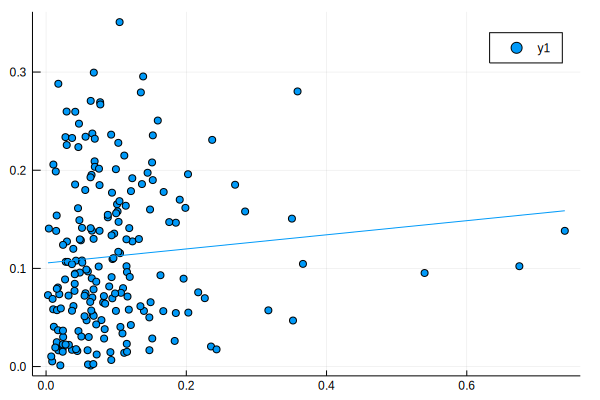

In [47]:
plot(resp_dev_rad, pred_dev_rad, seriestype = :scatter, smooth=true)

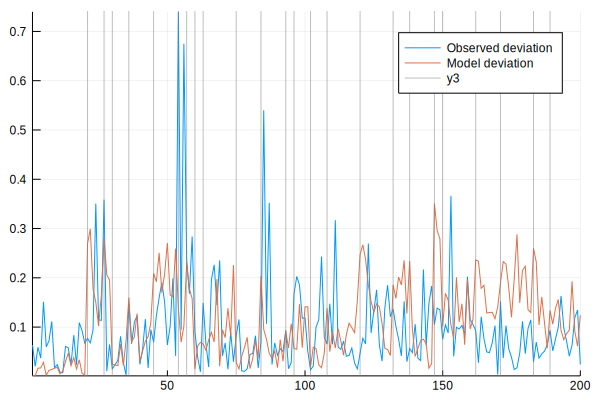

In [48]:
plot(hcat(resp_dev_rad, pred_dev_rad), lab=["Observed deviation", "Model deviation"])

@_ recall |> 
    @where(_, :subjid1.==1, :new_block .== 1) |> 
    @df _ plot!(:respnr, seriestype=:vline, color=GrayA(0.5, 0.5))

In [49]:
cor(resp_dev_rad, pred_dev_rad)

0.09127699267944844

In [50]:
pred_radius = norm.(recalled)

200-element Array{Float64,1}:
 0.0313299 
 0.0281727 
 0.00092249
 0.0336333 
 0.00267741
 0.0106706 
 0.019182  
 0.021844  
 0.00928018
 0.022072  
 0.0149491 
 0.0126682 
 0.0248385 
 ⋮         
 0.330768  
 0.123224  
 0.103224  
 0.445536  
 0.333808  
 0.327923  
 0.21716   
 0.20708   
 0.340195  
 0.334202  
 0.397331  
 0.369007  

In [51]:
hcat(recalled...)'

200×2 Array{Float64,2}:
  0.0308519     0.0054517  
  0.0281303     0.0015448  
  0.000554627   0.000737141
  0.0336065    -0.00134185 
 -0.00266282   -0.000279085
  0.0106697    -0.000139061
  0.01915       0.00110875 
  0.0217771     0.00170841 
  0.00921745    0.00107726 
  0.0220718    -9.59695e-5 
  0.014922      0.000900933
  0.0126565     0.00054541 
  0.0247673     0.0018788  
  ⋮                        
 -0.0111392    -0.33058    
  0.00667799   -0.123043   
  0.0179475    -0.101652   
 -0.0907937    -0.436187   
 -0.0324933    -0.332223   
 -0.0368426    -0.325847   
 -0.025601     -0.215646   
 -0.0307894    -0.204778   
 -0.115038     -0.320154   
 -0.0835197    -0.323598   
 -0.0682433    -0.391426   
 -0.106975     -0.353161   

# Recreating plots from paper

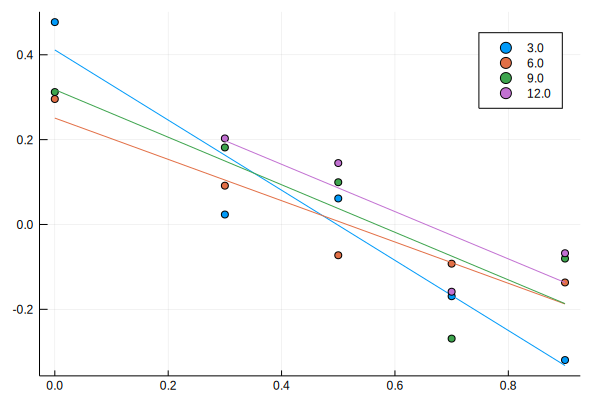

In [52]:
@_ recall |>
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], new_rho_bias = mean(:new_rho_bias)) |>
    @with(_, plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=^([:scatter])))

## Just first subject

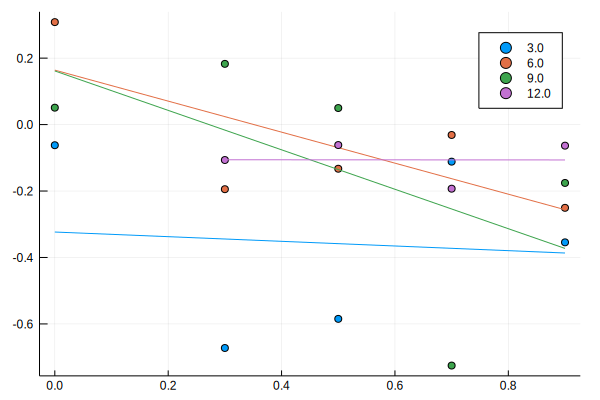

In [53]:
@_ recall |>
    @where(_, :block .> 1, :subjid1 .== 1) |>
    @by(_, [:rad, :rep_number], new_rho_bias = mean(:new_rho_bias)) |>
    @with(_, plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=^([:scatter])))

Extremely noisy!

## With predictions

First want to make sure I'm understanding what the bias is accurately:

In [54]:
@_ recall |> @select(_, :rad, :rho, :new_rho_bias, :rho_resp) |> @transform(_, resp_minus_rho = :rho_resp .- :rho)

,rad,rho,new_rho_bias,rho_resp,resp_minus_rho
1,0.0,0.2032,0.0677,0.2709,0.0677
2,0.0,0.1751,-0.1162,0.0589,-0.1162
3,0.0,-0.1007,0.3643,0.465,0.5657
4,0.0,0.318,0.1782,0.4962,0.1782
5,0.0,-0.1964,0.6045,0.8009,0.9973
6,0.0,0.0535,0.2961,0.3496,0.2961
7,0.0,0.1975,0.4522,0.6497,0.4522
8,0.0,0.2248,0.3549,0.5797,0.3549
9,0.0,-0.0469,0.105,0.1519,0.1988
10,0.0,0.254,-0.1168,0.1372,-0.1168


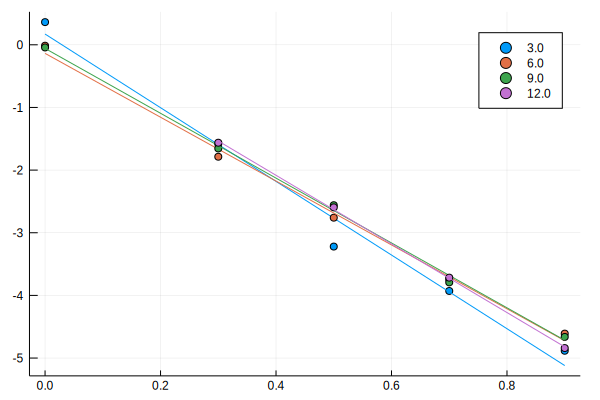

In [55]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    @transform(_, pred_rho_bias = norm.(recalled) .- :rho) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias)) |>
    @df(_, plot(:rad, :pred_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter))

Okay this is _qualitatively_ not that far off actually.  Bigger slope (more bias) for shorter blocks, overall negative slope (shrinkage towards the overall mean).  Big difference with the actual results is that the intercept is 0: things are being shrunk towards the overall prior which has zero mean.

## All subjects

In [56]:
function model_recall(d::AbstractDataFrame, N::Int, prior::NormalInverseWishart, stateprior, Sx::Matrix)
    xy_vecs = map(vec, julienne(hcat(d[:x], d[:y]), (*,:)))
    ps = ChenLiuParticles(N, prior, stateprior)

    recalled = Vector{Vector{Float64}}()
    ps2 = filter!(ps, xy_vecs,
                  cb=(p,y)->push!(recalled, recall_est(y, Sx, p)))
    DataFrame(x_mod = first.(recalled),
              y_mod = last.(recalled),
              rho_mod = norm.(recalled))
end

model_recall (generic function with 1 method)

In [57]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, 100, prior, StickyCRP(1.0, 0.9), eye(2))

Fitting particles...100%|███████████████████████████████| Time: 0:00:02


,x_mod,y_mod,rho_mod
1,0.029416,0.00519796,0.0298717
2,0.0283522,0.00258655,0.02847
3,0.0118711,0.00159787,0.0119781
4,0.0245843,0.000100666,0.0245845
5,0.0101769,4.11184e-5,0.010177
6,0.0115699,-1.40468e-5,0.0115699
7,0.015092,0.000508331,0.0151006
8,0.0176794,0.00098554,0.0177069
9,0.013738,0.000964864,0.0137718
10,0.0175964,0.000511476,0.0176038


In [58]:
recall_mod = by(recall, :subjid1, d->model_recall(d, 100, prior, StickyCRP(1.0, 0.9), eye(2).*0.00000001))

Fitting particles...100%|███████████████████████████████| Time: 0:00:02
Fitting particles...100%|███████████████████████████████| Time: 0:00:02
Fitting particles...100%|███████████████████████████████| Time: 0:00:02
Fitting particles...100%|███████████████████████████████| Time: 0:00:03
Fitting particles...100%|███████████████████████████████| Time: 0:00:03
Fitting particles...100%|███████████████████████████████| Time: 0:00:02
Fitting particles...100%|███████████████████████████████| Time: 0:00:02
Fitting particles...100%|███████████████████████████████| Time: 0:00:02


,subjid1,x_mod,y_mod,rho_mod
1,1.0,0.0318469,0.00562752,0.0323403
2,1.0,0.0278656,0.000370634,0.027868
3,1.0,-0.0160184,-0.000520782,0.0160269
4,1.0,0.0504518,-0.00401431,0.0506113
5,1.0,-0.0312425,-0.000984465,0.031258
6,1.0,0.00850297,-0.000448522,0.00851479
7,1.0,0.0312967,0.00292533,0.0314331
8,1.0,0.0355355,0.00415872,0.035778
9,1.0,-0.00730867,0.00151658,0.00746436
10,1.0,0.0403415,-0.00260159,0.0404253


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:840
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0 (repeats 2 times)
 [6] hcat(::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:871
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/dave/.julia/v0.6/IJulia/src/execute_request.jl:158
 [8] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/dave/.julia/v0.6/Com

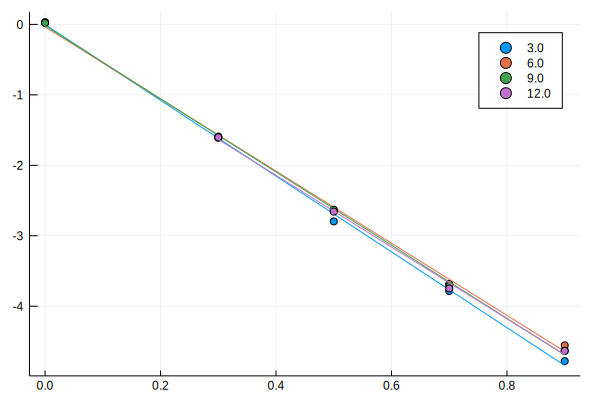

In [59]:
@_ hcat(recall, recall_mod) |>
    @transform(_, pred_rho_bias = :rho_mod .- :rho) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias)) |>
    @df(_, plot(:rad, :pred_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter))


In [60]:
@with hcat(recall, recall_mod) permutedims(hcat(:x, :x_mod), (2,1))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:840
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0 (repeats 2 times)
 [6] hcat(::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:871
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/dave/.julia/v0.6/IJulia/src/execute_request.jl:158
 [8] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/dave/.julia/v0.6/Com

2×1600 Array{Float64,2}:
 0.0318469  0.0278656  -0.0160184  …  0.0128465  -0.0323571  0.0481083
 0.0318469  0.0278656  -0.0160184     0.0128465  -0.0323571  0.0481082